# 2. Market Basket Analysis

In [501]:
# Libraries needed
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.patches import Wedge

## 2.1 Shopify Products Data Frame

In [502]:
shopify_products = pd.read_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/1.- Data Collection, Preprocessing and EDA/Shopify Products for Analysis.csv', index_col=False)
shopify_products.head()

,Sale ID,Date,Order ID,Order,Product,Net sales,Payment type,Credit card,Credit card type,Billing country,Refunds,Net payments,returned_item_rate,product_type,sales_count
0,13087920095372,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
1,13087920160908,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
2,13087920193676,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,20.95,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
3,13087920029836,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,13.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
4,13087920062604,2022-06-01 09:55:27+00:00,4089814286476,#19176,breakfast pastry platter,40.00,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.00724,breakfast,119


In [503]:
print('Number of unique Products:', shopify_products['Product'].nunique())
print('Number of unique Product Type:', shopify_products['product_type'].nunique())

pd.set_option('display.max_rows', None)

# Get the value counts for each product
product_counts = shopify_products['Product'].value_counts()

# Sort the products alphabetically by their names
sorted_product_counts = product_counts.sort_index()

print('\n Number of and Names of Unique Products:')
print(sorted_product_counts)

pd.reset_option('display.max_rows')  # Reset to default setting

Number of unique Products: 125
Number of unique Product Type: 17

 Number of and Names of Unique Products:
Product
12 dinner rolls                                     641
2 iced shortbread                                    58
2 lb fruitcake                                       93
24 piece square tray                                452
2lb mac  cheese                                     149
4 kaisers                                            51
500 ml potato leek soup                              64
500ml rum sauce                                      87
6 banana chocolate chunk muffins                    114
6 blueberry cranberry bran muffins                   55
6 blueberry lemon buns                               66
6 brownies                                          179
6 buttermilk biscuits                                65
6 carrot ginger pecan muffins                        63
6 cheddar  herb scones                               70
6 chocolate chunk cookies                    

### 2.1.1 Handling Refunds

Handling refunds correctly is crucial for Market Basket Analysis (MBA) because they affect the total purchase behavior represented in the data. Refunds can complicate the analysis by duplicating or distorting the actual purchase data. The data frame will be adjusted as follows: 

1. Separate Refunds from Sales:
Separate the refunded items from the purchased items before creating the basket matrix. Refunds represent a reversal of sales and should not be included in the basket analysis as purchases.

2. Adjust Sales Count for Refunds:
Adjust the sales count for each product to reflect the net sales after accounting for refunds.

* **Filter out Refunded Items**

Rows where refunds are greater than $0 will be removed for the purpose of creating the basket matrix. This will ensure that only products that were actually purchased are considered.

In [504]:
purchase_data = shopify_products[shopify_products['Refunds']>=0]
print('Rows in New Data Frame:', purchase_data.shape[0])
print('Rows in Original Data Frame:', shopify_products.shape[0])


Rows in New Data Frame: 25089
Rows in Original Data Frame: 26394


In [505]:
# Save the dataframe with no refunds 
purchase_data.to_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/2.- Market Basket Analysis/Purchase Data - No Refunds.csv', index=False)
purchase_data.head()

,Sale ID,Date,Order ID,Order,Product,Net sales,Payment type,Credit card,Credit card type,Billing country,Refunds,Net payments,returned_item_rate,product_type,sales_count
0,13087920095372,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
1,13087920160908,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
2,13087920193676,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,20.95,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
3,13087920029836,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,13.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
4,13087920062604,2022-06-01 09:55:27+00:00,4089814286476,#19176,breakfast pastry platter,40.00,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.00724,breakfast,119


### 2.1.2 Adjust Product Counts per Order

* **Count of Products per Order**

So far, in the data frame, the `sales_count` in each row represents a product's total sales count across all orders. For the purposed of the MBA, this should be the count of products in an order. So a new column will be created. 

In [506]:
# Group by 'Order ID' and 'Product', and count occurrences
order_product_count = purchase_data.groupby(['Order ID', 'Product']).size().reset_index(name='Count Per Order')
order_product_count.head(10)

,Order ID,Product,Count Per Order
0,4089814286476,baked fruit tart,2
1,4089814286476,breakfast pastry platter,1
2,4089814286476,buttertarts,3
3,4089902530700,sandwich platter,1
4,4089942933644,cookie trays individually wrapped,1
5,4089973964940,chocolate buttercake,1
6,4089998246028,apple raisin walnut loaf,1
7,4090011058316,chocolate chip cookie cake,1
8,4090011058316,coconut cream pie,1
9,4090015187084,6 cupcakes,1


### 2.1.3 Create Basket Matrix using `Product`

Data will be transformed into a basket matrix where rows are orders, columns are products, and values indicate the count of each product in the order.

In [507]:
# Pivot table to create basket matrix
basket_matrix = order_product_count.pivot_table(index='Order ID', columns='Product', values='Count Per Order', aggfunc='sum').fillna(0)

# Convert the basket_matrix to binary
basket_matrix_binary = basket_matrix.map(lambda x: 1 if x > 0 else 0)

basket_matrix_binary.head()

Product,12 dinner rolls,2 iced shortbread,2 lb fruitcake,24 piece square tray,2lb mac cheese,4 kaisers,500 ml potato leek soup,500ml rum sauce,6 banana chocolate chunk muffins,6 blueberry cranberry bran muffins,...,trifle cake,turkey gravy thanksgiving menu,vanilla buttercake,vanilla vegan cake,vegan chocolate cake,warm spinach artichoke dip,white bread,white chocolate cheesecake choice of fruit,whole wheat bread,will you be my valentine treat box
Order ID,,,,,,,,,,,,,,,,,,,,,
4089814286476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4089902530700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4089942933644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4089973964940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4089998246028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.1.3.1 Market Basket Analysis using the frequent itemsets and association rules algorithms - Apriori

In [508]:
# Convert matrix binary to Boolean Matrix
basket_matrix_binary = basket_matrix.map(lambda x: x > 0)

# Generate frequent itemsets
frequent_itemsets = apriori(basket_matrix_binary, min_support=0.005, use_colnames=True)

# Generate the association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)

# Sort the rules by lift for better insights
rules = rules.sort_values('lift', ascending=False)

# Print the number of rules generated
print(f"Number of rules generated: {len(rules)}")

# Display the top 50 rules
print(rules.head(50))

Number of rules generated: 18
                   antecedents                 consequents  \
15            (crudit platter)             (fruit platter)   
14             (fruit platter)            (crudit platter)   
17            (crudit platter)          (sandwich platter)   
16          (sandwich platter)            (crudit platter)   
12       (scottish shortbread)  (assorted holiday cookies)   
13  (assorted holiday cookies)       (scottish shortbread)   
7                  (apple pie)         (9inch pumpkin pie)   
6          (9inch pumpkin pie)                 (apple pie)   
8              (blueberry pie)                 (apple pie)   
9                  (apple pie)             (blueberry pie)   
1          (9inch pumpkin pie)           (12 dinner rolls)   
0            (12 dinner rolls)         (9inch pumpkin pie)   
3                  (apple pie)           (12 dinner rolls)   
2            (12 dinner rolls)                 (apple pie)   
11                 (apple pie)          

In [509]:
# Save the Results
# Save the rules DataFrame to a CSV file
rules.to_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/2.- Market Basket Analysis/Market Basket Rules.csv', index=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,(crudit platter),(fruit platter),0.014593,0.011368,0.005724,0.392265,34.505427,0.005559,1.626749,0.985399
14,(fruit platter),(crudit platter),0.011368,0.014593,0.005724,0.503546,34.505427,0.005559,1.984891,0.982185
17,(crudit platter),(sandwich platter),0.014593,0.015561,0.005886,0.403315,25.918730,0.005659,1.649847,0.975656
16,(sandwich platter),(crudit platter),0.015561,0.014593,0.005886,0.378238,25.918730,0.005659,1.584863,0.976615
12,(scottish shortbread),(assorted holiday cookies),0.013626,0.049262,0.007256,0.532544,10.810389,0.006585,2.033857,0.920033
13,(assorted holiday cookies),(scottish shortbread),0.049262,0.013626,0.007256,0.147300,10.810389,0.006585,1.156765,0.954518
7,(apple pie),(9inch pumpkin pie),0.063211,0.048698,0.016690,0.264031,5.421807,0.013611,1.292584,0.870590
6,(9inch pumpkin pie),(apple pie),0.048698,0.063211,0.016690,0.342715,5.421807,0.013611,1.425241,0.857309
8,(blueberry pie),(apple pie),0.017980,0.063211,0.005079,0.282511,4.469371,0.003943,1.305650,0.790467
9,(apple pie),(blueberry pie),0.063211,0.017980,0.005079,0.080357,4.469371,0.003943,1.067828,0.828633


#### 2.1.3.2 Market Basket Analysis Results

**Overview:**

The market basket analysis generated 18 association rules. These rules help identify which products are frequently purchased together and can provide insights into customer purchasing behavior. The analysis was conducted using the Apriori algorithm, and the resulting rules were evaluated based on metrics such as support, confidence, lift, and leverage.

**Key Findings:**

1. **Strong Association Rules:**
   - **Rule 1:** Customers who purchased a *crudit platter* are highly likely to also purchase a *fruit platter*, with a lift value of 34.51. This suggests a very strong association between these two items.
   - **Rule 2:** The inverse is also true; customers buying a *fruit platter* are strongly likely to buy a *crudit platter* as well, with the same lift value of 34.51. This indicates that these two products are often bought together and could be bundled in promotions.
   - **Rule 3:** A strong association exists between *crudit platter* and *sandwich platter*, with a lift value of 25.92. This high lift value suggests that these items are frequently bought together, potentially indicating complementary products.
   - **Rule 4:** Similarly, customers who buy a *sandwich platter* are likely to purchase a *crudit platter*, with a lift value of 25.92. This reinforces the complementary relationship between these products.

2. **Moderate Associations:**
   - **Rule 5:** The association between *scottish shortbread* and *assorted holiday cookies* has a lift value of 10.81. This indicates a moderate relationship, suggesting that these items are sometimes purchased together.
   - **Rule 6:** The reverse association also holds true with the same lift value, highlighting a reciprocal purchasing pattern between these products.

3. **Weaker Associations:**
   - **Rule 7:** The association between *apple pie* and *9inch pumpkin pie* shows a lift value of 5.42, which is relatively weaker compared to the stronger associations but still indicates a notable connection.
   - **Rule 8:** Similarly, *9inch pumpkin pie* and *apple pie* have the same lift value, suggesting some degree of co-purchase behavior but less pronounced compared to the stronger rules.

4. **Additional Observations:**
   - **Rule 9:** *Apple pie* and *blueberry pie* have a lift value of 4.47. This weaker association might still be useful for cross-selling or promotional activities.
   - **Rule 10:** The lift value for the association between *12 dinner rolls* and *apple pie* is 4.17. Although weaker, it indicates that these items are purchased together more often than would be expected by chance.

**Metrics Explained:**
- **Support:** Indicates how frequently the itemset appears in the dataset.
- **Confidence:** Reflects the likelihood of purchasing the consequent given the antecedent.
- **Lift:** Measures the strength of the association between antecedent and consequent. A lift value greater than 1 suggests a positive association.
- **Leverage:** Shows the degree to which the antecedent and consequent vary together. Higher leverage indicates a stronger association.
- **Conviction:** Measures the likelihood of observing the consequent in the absence of the antecedent. Higher values indicate stronger rules.
- **Zhang's Metric:** Provides an additional measure of the strength of the rule, with higher values indicating stronger rules.

**Recommendations:**
- **Promotions and Bundling:** Based on the strong associations, consider bundling products like the *crudit platter* and *fruit platter* or *crudit platter* and *sandwich platter* in promotional offers.
- **Cross-Selling:** Utilize moderate associations such as *scottish shortbread* and *assorted holiday cookies* to encourage cross-selling.
- **Stock Management:** Understanding which products are frequently bought together can help optimize stock levels and ensure popular combinations are always available.

Overall, the market basket analysis provides valuable insights into customer purchasing behavior, allowing for more targeted marketing strategies and improved inventory management.




#### 2.1.3.3 Additional Business Insights for Online Transactions

Based on the market basket analysis conducted for our online store, several valuable business insights have emerged that can help enhance our operations and customer engagement:

1. **Customer Behavior Analysis:**
   - **Frequent Combinations:** Our analysis reveals which products are frequently purchased together. This insight is crucial for personalizing customer experiences and could be leveraged to offer tailored product recommendations. For instance, if customers who purchase "apple pie" often buy "blueberry pie," we can use this information to recommend complementary items to customers during their online shopping experience.
   - **Cross-Selling Opportunities:** Items with high lift values suggest significant associations between product pairs. By strategically bundling these items together in promotional offers, we can enhance cross-selling efforts and potentially increase sales.

2. **Targeted Marketing Campaigns:**
   - **Personalized Offers:** The association rules can be applied to create targeted marketing campaigns. For example, special promotions or discounts can be offered on products frequently bought together, thereby encouraging repeat purchases and boosting customer satisfaction.
   - **Email Marketing:** Utilizing the association insights, we can design email marketing campaigns that promote complementary products based on previous purchase patterns, thereby increasing engagement and sales.

3. **Inventory Management:**
   - **Stock Management:** Understanding which products are often purchased together helps in optimizing inventory levels. Ensuring that high-lift product pairs are well-stocked can prevent stockouts and meet customer demand more effectively.

4. **Website Optimization:**
   - **Product Recommendations:** Implementing a recommendation engine on our website based on the most common associations can enhance the shopping experience. By suggesting items that frequently appear together, we can increase the average order value and improve customer satisfaction.
   - **Search and Filter Options:** Enhancing search and filter functionalities to highlight complementary products can facilitate easier discovery and boost overall sales.

5. **Customer Segmentation:**
   - **Segment Analysis:** Analyzing customer segments based on purchasing behavior enables us to tailor marketing strategies and promotions to specific customer groups. This targeted approach can enhance customer engagement and loyalty.

6. **Promotional Strategies:**
   - **Bundles and Discounts:** Creating special bundles or offering discounts on products frequently purchased together can attract more customers and increase sales. This strategy aligns with the high lift values observed in our analysis.
   - **Seasonal Promotions:** Utilizing insights from the analysis to plan seasonal promotions ensures that our offerings are aligned with customer preferences and trends.

7. **Behavioral Trends:**
   - **Trending Products:** Monitoring shifts in association rules over time helps identify emerging trends in customer preferences. Adapting our product offerings and marketing strategies based on these trends can keep our store competitive and relevant.

8. **Customer Feedback:**
   - **Feedback Integration:** Incorporating customer feedback regarding product recommendations and promotions will allow us to refine our strategies further. Understanding actual customer experiences helps in tailoring our approach to better meet customer needs.

By integrating these insights into our online store's operations, we can significantly enhance customer experience, optimize inventory management, and develop more effective marketing strategies.


#### 2.1.3.4 Combine MBA Results DataFrame with Shopify Products columns (sales counts and product type)

In [510]:
# Convert frozenset format to string
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

# Create mappings from purchase_data
product_sales_count = purchase_data.set_index('Product')['sales_count'].to_dict()
product_type = purchase_data.set_index('Product')['product_type'].to_dict()

# Map antecedents and consequents
rules['antecedent_sales_count'] = rules['antecedents'].map(product_sales_count)
rules['antecedent_product_type'] = rules['antecedents'].map(product_type)
rules['consequent_sales_count'] = rules['consequents'].map(product_sales_count)
rules['consequent_product_type'] = rules['consequents'].map(product_type)

#Save the updated DataFrame
rules.to_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/2.- Market Basket Analysis/Rules and Product Types and Sales Counts.csv')

# Display the updated DataFrame
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_sales_count,antecedent_product_type,consequent_sales_count,consequent_product_type
15,crudit platter,fruit platter,0.014593,0.011368,0.005724,0.392265,34.505427,0.005559,1.626749,0.985399,434,catering,177,catering
14,fruit platter,crudit platter,0.011368,0.014593,0.005724,0.503546,34.505427,0.005559,1.984891,0.982185,177,catering,434,catering
17,crudit platter,sandwich platter,0.014593,0.015561,0.005886,0.403315,25.918730,0.005659,1.649847,0.975656,434,catering,272,catering
16,sandwich platter,crudit platter,0.015561,0.014593,0.005886,0.378238,25.918730,0.005659,1.584863,0.976615,272,catering,434,catering
12,scottish shortbread,assorted holiday cookies,0.013626,0.049262,0.007256,0.532544,10.810389,0.006585,2.033857,0.920033,179,cookies,1393,cookies
13,assorted holiday cookies,scottish shortbread,0.049262,0.013626,0.007256,0.147300,10.810389,0.006585,1.156765,0.954518,1393,cookies,179,cookies
7,apple pie,9inch pumpkin pie,0.063211,0.048698,0.016690,0.264031,5.421807,0.013611,1.292584,0.870590,888,pie,679,pie
6,9inch pumpkin pie,apple pie,0.048698,0.063211,0.016690,0.342715,5.421807,0.013611,1.425241,0.857309,679,pie,888,pie
8,blueberry pie,apple pie,0.017980,0.063211,0.005079,0.282511,4.469371,0.003943,1.305650,0.790467,268,pie,888,pie
9,apple pie,blueberry pie,0.063211,0.017980,0.005079,0.080357,4.469371,0.003943,1.067828,0.828633,888,pie,268,pie


#### 2.1.3.5 Visualize the MBA Rules using the sales count and product types

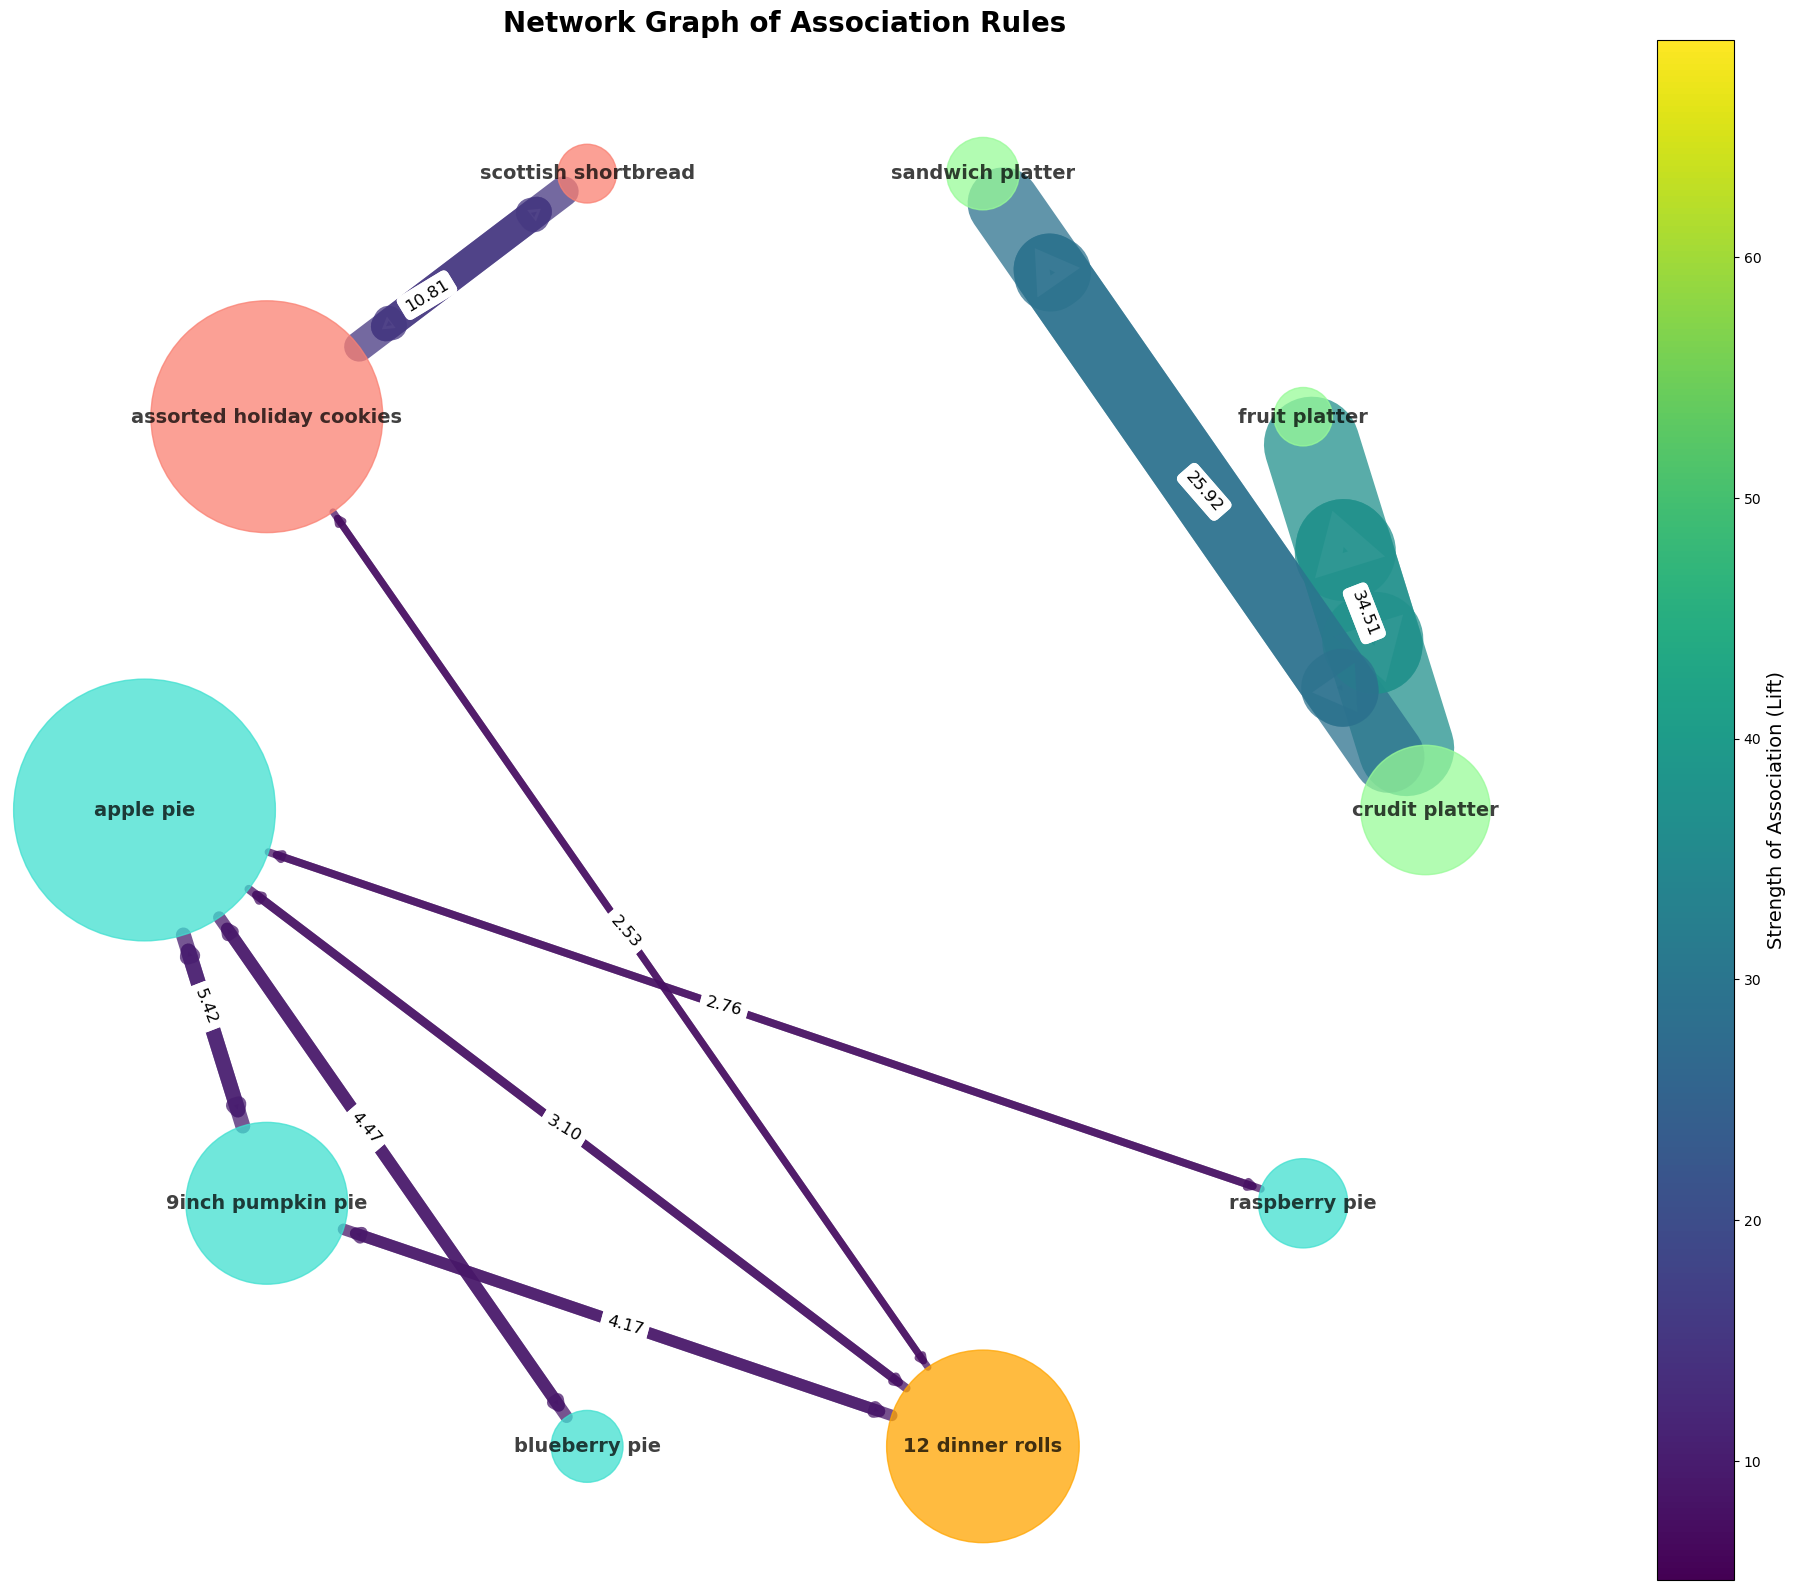

In [493]:
# Create a Network Graph
G = nx.DiGraph()
for _, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

# Calculate node sizes based on sales count
node_sizes = {}
all_nodes = set(rules['antecedents']).union(set(rules['consequents']))
for node in all_nodes:
    antecedent_count = rules[rules['antecedents'] == node]['antecedent_sales_count'].sum()
    consequent_count = rules[rules['consequents'] == node]['consequent_sales_count'].sum()
    total_sales_count = antecedent_count + consequent_count
    node_sizes[node] = total_sales_count * 5  # Adjust multiplier for better size scaling

# Define pastel colors for product types
pastel_colors = {
    'catering': 'palegreen',  
    'pie': 'turquoise',   
    'cookies': 'salmon',  
    'bread': 'orange',
    # Add additional product types if needed
}

# Set node colors based on product types
node_colors = []
for node in G.nodes():
    antecedent_type = rules[rules['antecedents'] == node]['antecedent_product_type']
    consequent_type = rules[rules['consequents'] == node]['consequent_product_type']
    # Take the most common type if multiple types are present
    if not antecedent_type.empty:
        node_colors.append(pastel_colors.get(antecedent_type.values[0], '#D3D3D3'))  # Light Gray
    elif not consequent_type.empty:
        node_colors.append(pastel_colors.get(consequent_type.values[0], '#D3D3D3'))  # Light Gray
    else:
        node_colors.append('#D3D3D3')  # Light Gray

# Use Circular Layout for the graph
pos = nx.circular_layout(G) 

# Calculate edge weights and colors based on lift
edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]  # Adjust multiplier for thickness
edge_colors = [plt.cm.viridis(G[u][v]['weight'] / max(edge_weights)) for u, v in G.edges()]

# Draw nodes, edges, and labels with adjusted parameters
fig, ax = plt.subplots(figsize=(25, 20))  # Adjust figure size as needed
nx.draw(G, pos, with_labels=True, node_size=[node_sizes.get(n, 1000) for n in G.nodes()],
        node_color=node_colors, edge_color=edge_colors, width=edge_weights,
        font_size=14, font_weight='bold', arrows=True, ax=ax, alpha=0.75)

# Format edge labels to 2 decimal places
labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax, font_size=12)

# Create a color bar legend for the edges
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Strength of Association (Lift)', fontsize=14)

# Save the combined plots
save_path = '/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Plots/Basket Market Analysis Results 1.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Set the title and show the plot
ax.set_title('Network Graph of Association Rules', fontsize=20, fontweight='bold')
plt.show()

#### **2.1.3.6 Analysis of Association Rules Network Graph for Bread & Butter Bakery's Online Store (Product-Level)**

##### **Overview**

The updated network graph provides an intricate look at associations between individual products from Bread & Butter Bakery's online store, highlighting the specific items that are frequently purchased together. The strength of these associations is visualized through the thickness and color intensity of the edges connecting the products, with the "Lift" metric serving as a key indicator of how much more likely two products are to be bought together compared to what would be expected by chance.

##### **Key Findings**

1. **Strong Product Associations**:
    - **Apple Pie and 9-Inch Pumpkin Pie**: The network shows a strong connection between "Apple Pie" and "9-Inch Pumpkin Pie," evidenced by a significant lift value of 5.42. This association suggests that these pies are frequently purchased together, particularly during holiday seasons, making them prime candidates for cross-promotion in seasonal bundles.
    - **Assorted Holiday Cookies and Scottish Shortbread**: Another notable pairing is between "Assorted Holiday Cookies" and "Scottish Shortbread," with a high lift value of 10.81. This strong association is ideal for holiday promotions, where both items could be bundled together to drive sales during festive periods.

2. **Prominent Products**:
    - **Apple Pie**: Serving as a central node in the graph, "Apple Pie" is highly connected to several other products, including "9-Inch Pumpkin Pie," "Blueberry Pie," "Raspberry Pie," and "12 Dinner Rolls." This indicates that "Apple Pie" plays a pivotal role in driving the purchase of related products, making it a critical item for upselling and cross-promotional strategies.
    - **12 Dinner Rolls**: This product also holds a central position in the network, with strong associations to various pie types. The prominence of "12 Dinner Rolls" suggests that it could be effectively marketed as part of meal deals or family-sized bundles, catering to customers seeking convenient and comprehensive meal options.

3. **Opportunities for Cross-Promotion**:
    - **Platter Associations**: The connections between "Sandwich Platter," "Crudité Platter," and "Fruit Platter" indicate that customers who purchase one platter are likely to buy another. This presents an opportunity to offer special deals on catering packages or party bundles, which could include combinations of these platters.
    - **Pie Combinations**: The strong ties between various pie types, such as "Apple Pie," "9-Inch Pumpkin Pie," and "Blueberry Pie," suggest a customer preference for variety. This could be leveraged by offering mix-and-match pie deals or discounts on multiple pie purchases.

4. **Product Isolation**:
    - **Fruit Platter**: The "Fruit Platter" is relatively isolated in the network, indicating that it is not frequently purchased alongside other items. To enhance its visibility and sales, it could be bundled with more popular items like the "Crudité Platter" or highlighted in promotional campaigns targeting health-conscious customers.

5. **Edge Strength and Interpretation**:
    - The thickness and color intensity of the edges in the graph clearly indicate the strength of the associations between products. The most intense and thickest edges represent the strongest associations, making it easy to identify key product pairings that should be the focus of promotional efforts.

##### **Implications for Business Strategy**

- **Promotion and Cross-Selling**:
    - The strong associations, such as between "Apple Pie" and "9-Inch Pumpkin Pie," as well as between "Assorted Holiday Cookies" and "Scottish Shortbread," suggest excellent opportunities for targeted promotions. Seasonal bundles featuring these pairings could be particularly effective.
    - Additionally, promoting platter combinations, like the "Sandwich Platter" and "Crudité Platter," could attract customers looking for catering options, further boosting sales.

- **Inventory Management**:
    - Given the strong connections between certain products, it will be important to ensure that sufficient inventory is maintained, especially during peak seasons. For example, keeping ample stock of both "Apple Pie" and "12 Dinner Rolls" will be crucial, as these items are often purchased together.

- **Customer Experience**:
    - By strategically placing frequently associated products near each other on the online store, the shopping experience can be optimized. This approach not only makes it easier for customers to find and purchase related items but also has the potential to increase the average transaction value.

##### **Conclusion**

The enhanced product-level Market Basket Analysis offers actionable insights into customer purchasing behavior at Bread & Butter Bakery's online store. By focusing on specific product pairings and leveraging these insights for strategic promotions and inventory management, the bakery can improve its online sales performance and better meet the needs of its customers. The updated network graph, with its emphasis on edge strength and color intensity, provides a clear visual guide to the most promising opportunities for cross-promotion and product bundling.


### 2.1.4 Create Basket Analysis using `Product Type`

In [512]:
purchase_data.head()

,Sale ID,Date,Order ID,Order,Product,Net sales,Payment type,Credit card,Credit card type,Billing country,Refunds,Net payments,returned_item_rate,product_type,sales_count
0,13087920095372,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
1,13087920160908,2022-06-01 09:55:27+00:00,4089814286476,#19176,buttertarts,22.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02301,pastry,368
2,13087920193676,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,20.95,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
3,13087920029836,2022-06-01 09:55:27+00:00,4089814286476,#19176,baked fruit tart,13.50,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.02238,pie,275
4,13087920062604,2022-06-01 09:55:27+00:00,4089814286476,#19176,breakfast pastry platter,40.00,Shopify Payments,Mastercard,Standard,Canada,0.0,147.15,0.00724,breakfast,119


In [514]:
# Group by 'Order ID' and 'product_type', and count occurrences
order_product_count = purchase_data.groupby(['Order ID', 'product_type']).size().reset_index(name='Count Per Order')
order_product_count.head(10)

# Pivot table to create basket matrix
basket_matrix = order_product_count.pivot_table(index='Order ID', columns='product_type', values='Count Per Order', aggfunc='sum').fillna(0)

# Convert the basket_matrix to binary
basket_matrix_binary = basket_matrix.map(lambda x: 1 if x > 0 else 0)


# Convert matrix binary to Boolean Matrix
basket_matrix_binary = basket_matrix.map(lambda x: x > 0)

# Generate frequent itemsets
frequent_itemsets = apriori(basket_matrix_binary, min_support=0.005, use_colnames=True)

# Generate the association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)

# Sort the rules by lift for better insights
rules = rules.sort_values('lift', ascending=False)

# Print the number of rules generated
print(f"Number of rules generated: {len(rules)}")

# Display the top 50 rules
print(rules.head(50))

# Save the Results
# Save the rules DataFrame to a CSV file
rules.to_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/2.- Market Basket Analysis/Market Basket Rules with Product Types.csv', index=False)
rules



Number of rules generated: 120
            antecedents         consequents  antecedent support  \
60            (holiday)           (savoury)            0.013626   
61            (savoury)           (holiday)            0.145126   
12             (muffin)             (bread)            0.013868   
13              (bread)            (muffin)            0.128598   
9             (holiday)             (bread)            0.013626   
8               (bread)           (holiday)            0.128598   
101           (savoury)    (bread, cookies)            0.145126   
96     (bread, cookies)           (savoury)            0.027655   
99              (bread)  (cookies, savoury)            0.128598   
98   (cookies, savoury)             (bread)            0.031525   
103      (pie, savoury)             (bread)            0.031847   
106             (bread)      (pie, savoury)            0.128598   
87              (bread)    (cakes, savoury)            0.128598   
86     (cakes, savoury)        

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
60,(holiday),(savoury),0.013626,0.145126,0.006611,0.485207,3.343346,0.004634,1.660617,0.710581
61,(savoury),(holiday),0.145126,0.013626,0.006611,0.045556,3.343346,0.004634,1.033454,0.819885
12,(muffin),(bread),0.013868,0.128598,0.005563,0.401163,3.119512,0.003780,1.455157,0.688992
13,(bread),(muffin),0.128598,0.013868,0.005563,0.043260,3.119512,0.003780,1.030722,0.779706
9,(holiday),(bread),0.013626,0.128598,0.005402,0.396450,3.082862,0.003650,1.443794,0.684959
...,...,...,...,...,...,...,...,...,...,...
33,(catering),(cakes),0.076191,0.489640,0.009998,0.131217,0.267987,-0.027309,0.587443,-0.747271
37,(cakes),(pastry),0.489640,0.066597,0.007982,0.016302,0.244782,-0.024626,0.948871,-0.858061
36,(pastry),(cakes),0.066597,0.489640,0.007982,0.119855,0.244782,-0.024626,0.579859,-0.767734
39,(cakes),(pie),0.489640,0.213094,0.021205,0.043306,0.203227,-0.083135,0.822527,-0.884819


#### 2.1.4.1 Visualize MBA Rules using the Product types

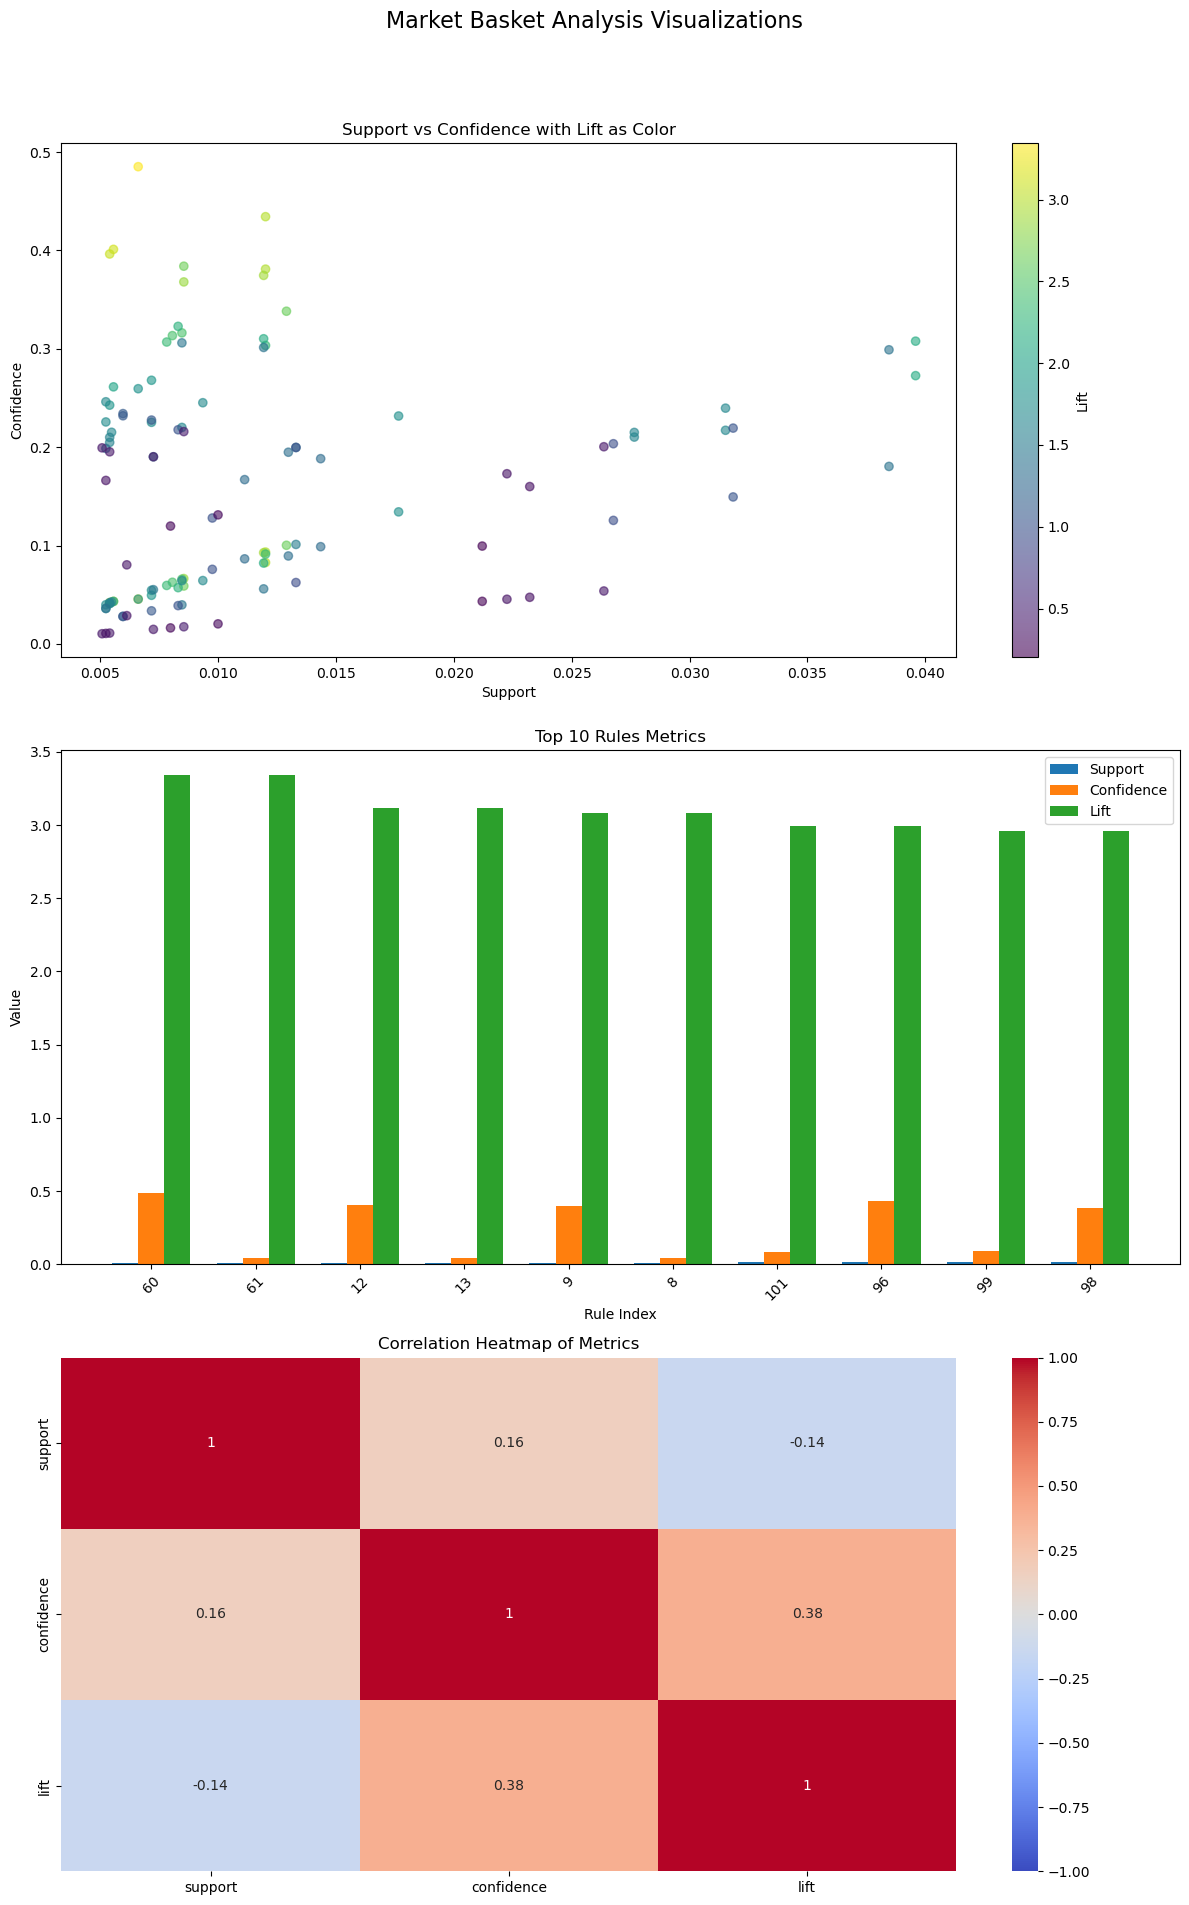

In [515]:
# Set up the figure and axes for the first four plots
fig, axs = plt.subplots(3, 1, figsize=(12, 20))
fig.suptitle('Market Basket Analysis Visualizations', fontsize=16)

# Scatter Plot
sc = axs[0].scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.6)
axs[0].set_xlabel('Support')
axs[0].set_ylabel('Confidence')
axs[0].set_title('Support vs Confidence with Lift as Color')

# Create a colorbar
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label('Lift')

# Bar Plot
top_rules = rules.head(10)
index = range(len(top_rules))
bar_width = 0.25

axs[1].bar(index, top_rules['support'], bar_width, label='Support')
axs[1].bar([i + bar_width for i in index], top_rules['confidence'], bar_width, label='Confidence')
axs[1].bar([i + 2 * bar_width for i in index], top_rules['lift'], bar_width, label='Lift')
axs[1].set_xlabel('Rule Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Top 10 Rules Metrics')
axs[1].set_xticks([i + bar_width for i in index])
axs[1].set_xticklabels(top_rules.index, rotation=45)
axs[1].legend()

# Heatmap
heatmap_data = rules[['support', 'confidence', 'lift']].corr()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[2])
axs[2].set_title('Correlation Heatmap of Metrics')

# Save the combined plots
save_path = '/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Plots/Basket Market Analysis Results 2.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Adjust layout for the first figure and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### **2.1.4.1.1 Summary of Market Basket Analysis Visualizations for Bread & Butter Bakery**

1. **Support vs. Confidence with Lift as Color**
   - The scatter plot visualizes the relationship between support and confidence for various rules, with the color gradient representing the lift. The distribution reveals clusters of rules with lower support and confidence, a common occurrence in market basket analysis, where the most frequent itemsets may not always have the highest confidence.
   - Notably, higher confidence does not always correspond with higher support. Some outliers exhibit high confidence and lower support, indicating that these may represent niche but strong associations. The color intensity highlighting high-lift rules suggests robust associations that, although less frequent, indicate significant co-purchase behavior.

2. **Top 10 Rules Metrics**
   - This bar chart showcases the top 10 association rules, emphasizing the lift, support, and confidence of each rule. Lift, represented in green, is the focal metric as it indicates the strength of an association compared to random chance.
   - The visual highlights the variability in support and confidence across rules with similar lift values. This suggests that while some rules are statistically strong, their practical occurrence in transactions may differ, underscoring the importance of considering all three metrics when making business decisions.

3. **Correlation Heatmap of Metrics**
   - The heatmap depicts the correlations between support, confidence, and lift. 
   - A slight negative correlation between support and lift is observed, implying that as an itemset's frequency (support) increases, the relative strength of its association (lift) might decrease. On the other hand, a positive correlation between confidence and lift indicates that higher-confidence rules tend to have stronger associations, making them particularly valuable for targeted marketing strategies.

**Overall Summary** 

These visualizations collectively offer a nuanced understanding of the relationships between different products in Bread & Butter Bakery's online store. The detailed insights provided by these graphs can guide the bakery in refining its marketing strategies, optimizing product placement, and enhancing cross-promotion efforts to improve customer experience and boost online sales. By focusing on rules with high lift and confidence, the bakery can identify and promote combinations of products that customers are more likely to purchase together, driving increased revenue and customer satisfaction.


#### 2.1.4.2 Create a sales count per product type column

In [516]:
# Group by 'Order ID' and 'product_type' and count the number of products of each type in each order
grouped_orders = purchase_data.groupby(['Order ID', 'product_type']).size().reset_index(name='Count Per Order PT')

# Pivot the table to get the count of orders containing each product type
pivot_table = grouped_orders.pivot_table(index='Order ID', columns='product_type', values='Count Per Order PT', fill_value=0)

# Summarize the number of transactions (orders) that contain each product type
product_type_transaction_count = pivot_table.astype(bool).sum(axis=0).reset_index()
product_type_transaction_count.columns = ['product_type', 'transaction_count']

# Display the result
product_type_transaction_count


,product_type,transaction_count
0,bread,1595
1,breakfast,473
2,cakes,6073
3,catering,945
4,cookies,1631
5,delivery,144
6,dessert,50
7,gourmet,292
8,holiday,169
9,loaf,264


#### 2.1.4.3 Add the sales count column to the rules data frame

In [517]:
# Convert the 'product_type_transaction_count' DataFrame into a dictionary for quick lookup
transaction_count_dict = product_type_transaction_count.set_index('product_type')['transaction_count'].to_dict()

# Function to handle product type lookup and create tuples of transaction counts
def get_transaction_count_tuple(items, transaction_count_dict):
    """ Return a tuple of transaction counts for the items in the frozenset/tuple """
    # Convert frozenset to tuple if necessary
    if isinstance(items, frozenset):
        items = tuple(items)
    
    # Handle tuples (which could now be converted from frozenset)
    if isinstance(items, tuple):
        counts = tuple(transaction_count_dict.get(item, 0) for item in items)
        print(f"Processing tuple {items}: {counts}")
        return counts
    else:
        # For single items, wrap in a tuple
        count = (transaction_count_dict.get(items, 0),)
        print(f"Processing item {items}: {count}")
        return count

# Apply the function to 'rules' DataFrame to calculate transaction counts
rules['antecedent_transaction_count'] = rules['antecedents'].apply(lambda x: get_transaction_count_tuple(x, transaction_count_dict))
rules['consequent_transaction_count'] = rules['consequents'].apply(lambda x: get_transaction_count_tuple(x, transaction_count_dict))

# Save and check the updated DataFrame
rules.to_csv('/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Data/2.- Market Basket Analysis/New Rules and Product Types and Sales Counts.csv')
print(rules[['antecedents', 'consequents', 'antecedent_transaction_count', 'consequent_transaction_count']].head())


Processing tuple ('holiday',): (169,)
Processing tuple ('savoury',): (1800,)
Processing tuple ('muffin',): (172,)
Processing tuple ('bread',): (1595,)
Processing tuple ('holiday',): (169,)
Processing tuple ('bread',): (1595,)
Processing tuple ('savoury',): (1800,)
Processing tuple ('bread', 'cookies'): (1595, 1631)
Processing tuple ('bread',): (1595,)
Processing tuple ('cookies', 'savoury'): (1631, 1800)
Processing tuple ('pie', 'savoury'): (2643, 1800)
Processing tuple ('bread',): (1595,)
Processing tuple ('bread',): (1595,)
Processing tuple ('cakes', 'savoury'): (6073, 1800)
Processing tuple ('savoury',): (1800,)
Processing tuple ('bread', 'cakes'): (1595, 6073)
Processing tuple ('breakfast',): (473,)
Processing tuple ('bread',): (1595,)
Processing tuple ('pie', 'cookies'): (2643, 1631)
Processing tuple ('bread',): (1595,)
Processing tuple ('bread',): (1595,)
Processing tuple ('scones',): (319,)
Processing tuple ('squares',): (316,)
Processing tuple ('cookies',): (1631,)
Processing t

In [518]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_transaction_count,consequent_transaction_count
60,(holiday),(savoury),0.013626,0.145126,0.006611,0.485207,3.343346,0.004634,1.660617,0.710581,"(169,)","(1800,)"
61,(savoury),(holiday),0.145126,0.013626,0.006611,0.045556,3.343346,0.004634,1.033454,0.819885,"(1800,)","(169,)"
12,(muffin),(bread),0.013868,0.128598,0.005563,0.401163,3.119512,0.003780,1.455157,0.688992,"(172,)","(1595,)"
13,(bread),(muffin),0.128598,0.013868,0.005563,0.043260,3.119512,0.003780,1.030722,0.779706,"(1595,)","(172,)"
9,(holiday),(bread),0.013626,0.128598,0.005402,0.396450,3.082862,0.003650,1.443794,0.684959,"(169,)","(1595,)"


#### 2.1.4.3 Create Network Graph of rules using Product type and sales count 

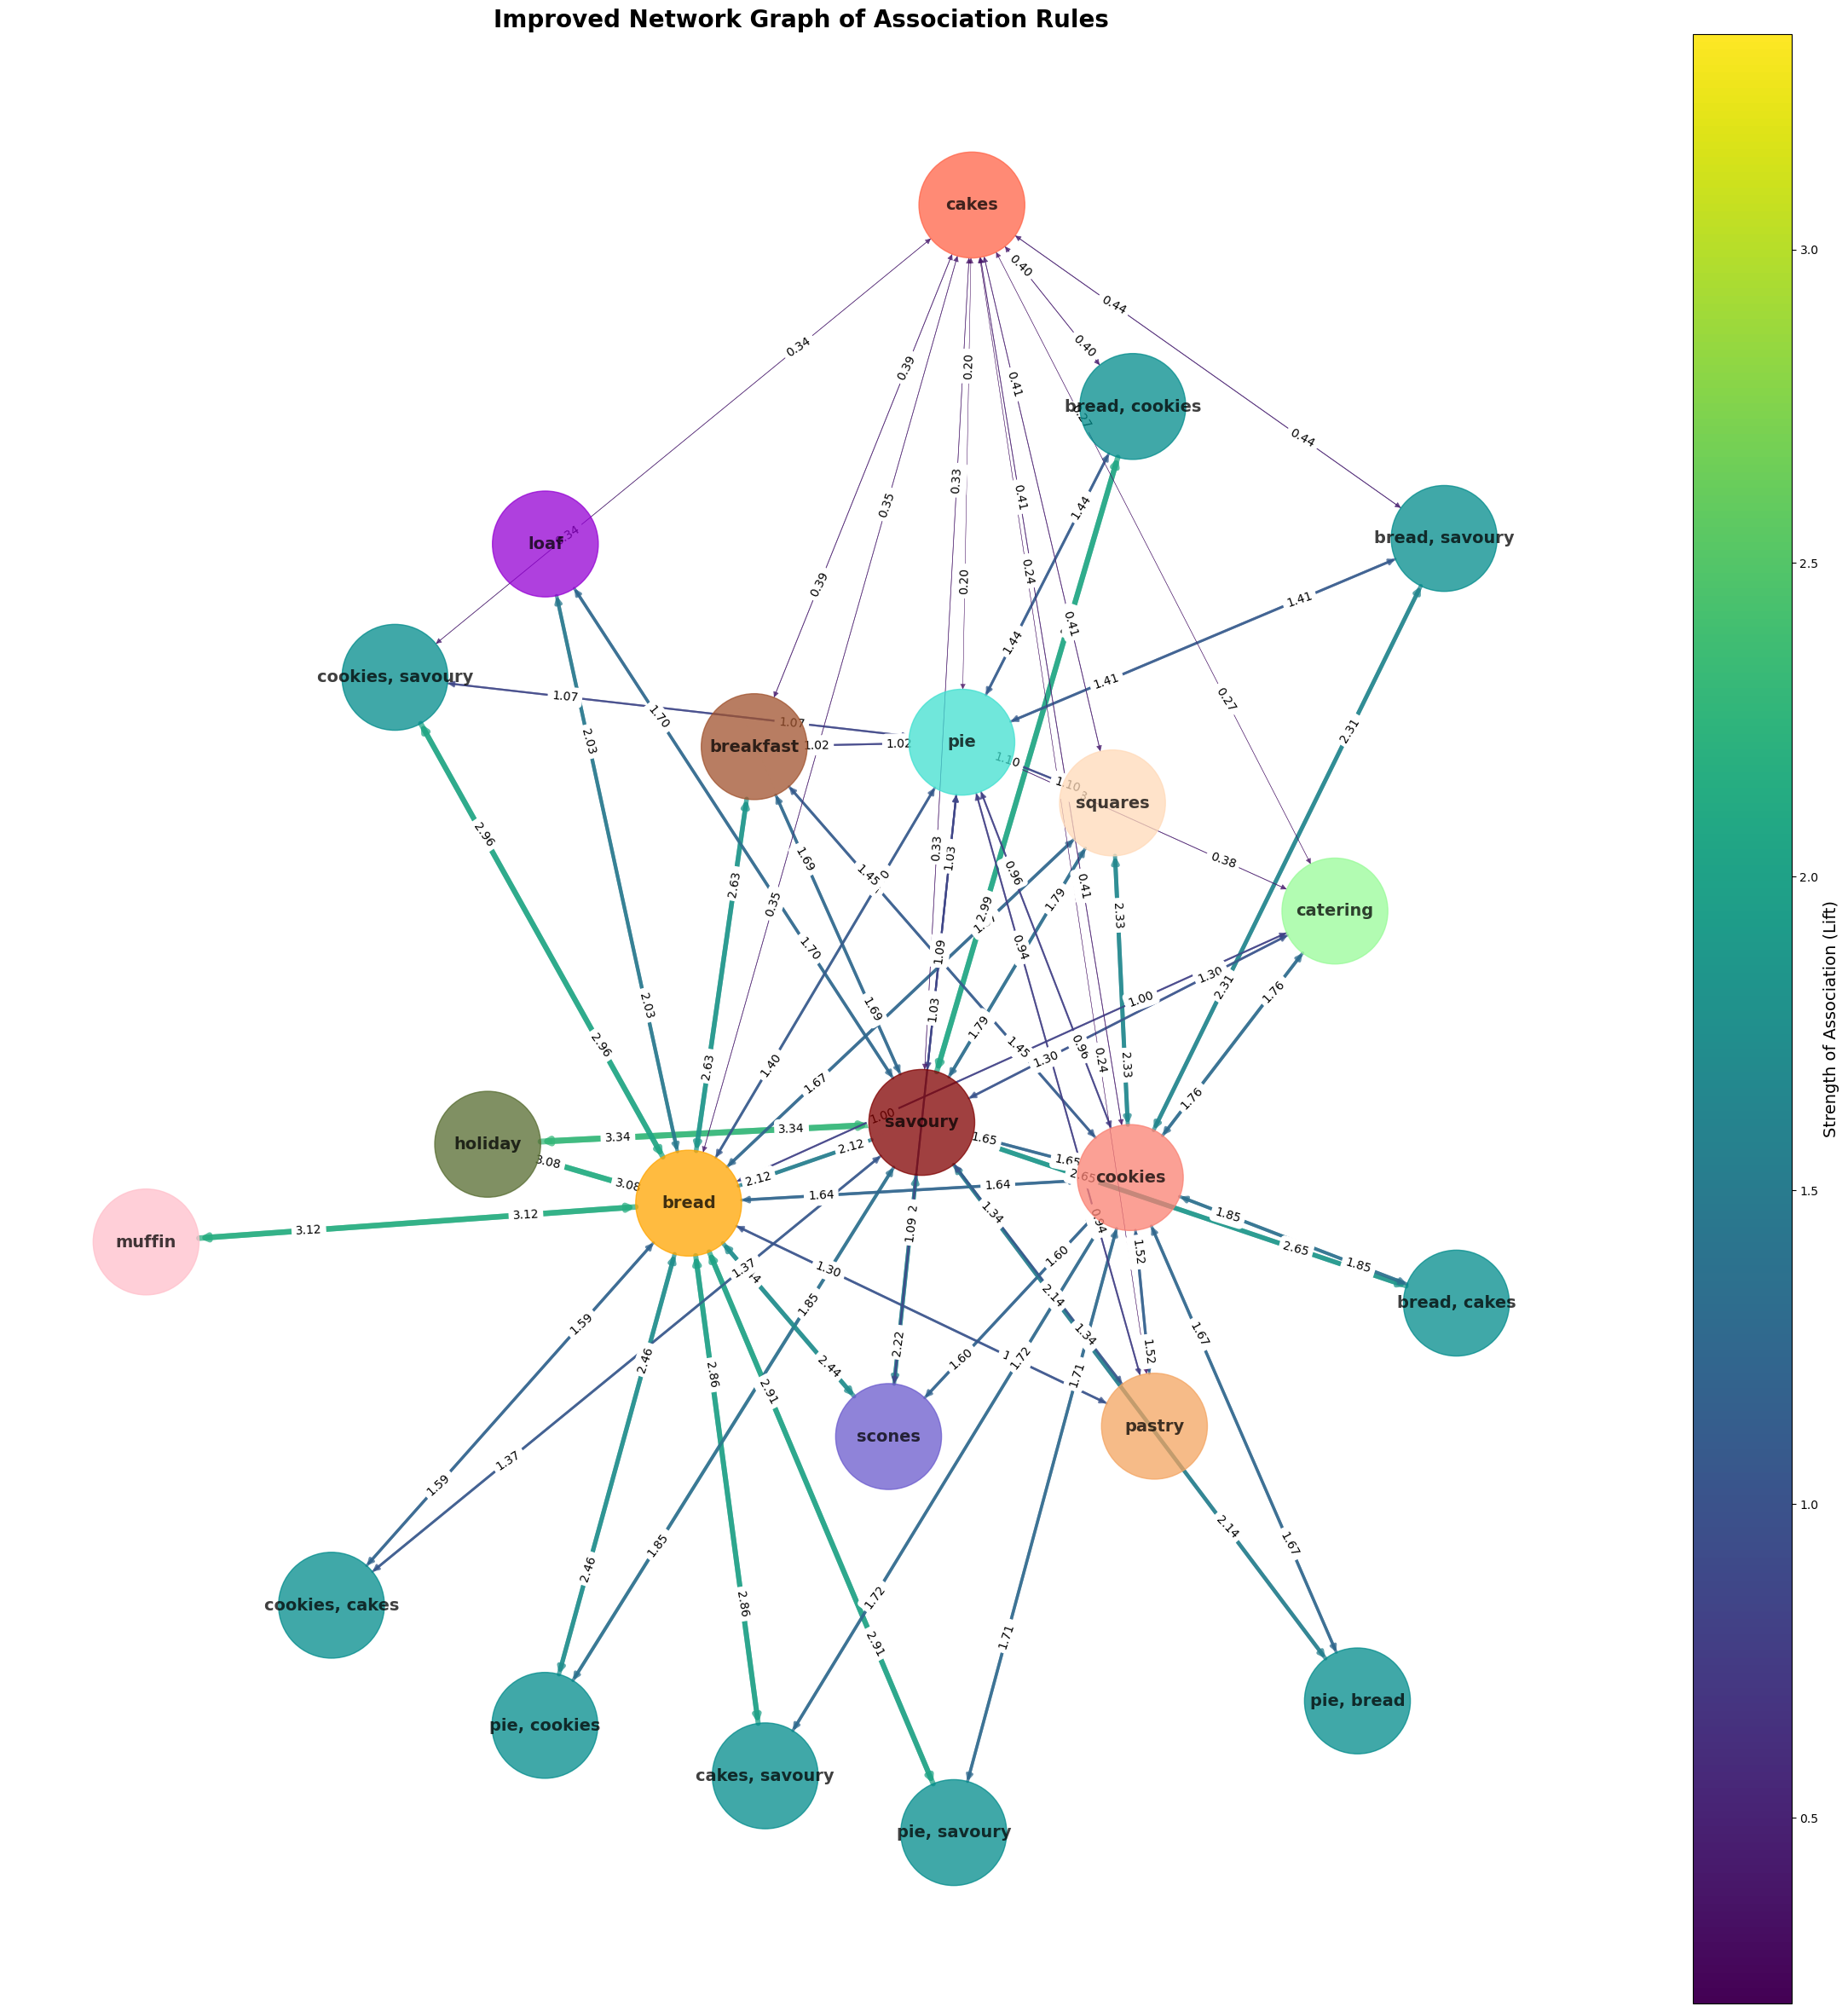

In [500]:
# Create the Network Graph
G = nx.DiGraph()
for _, row in rules.iterrows():
    antecedents = tuple(row['antecedents'])
    consequents = tuple(row['consequents'])
    G.add_edge(antecedents, consequents, weight=row['lift'])

# Calculate node sizes based on transaction counts
node_sizes = {}
for node in set(rules['antecedents']).union(set(rules['consequents'])):
    size = 0
    # Sum the transaction counts within tuples for antecedents and consequents
    antecedent_counts = rules[rules['antecedents'] == frozenset(node)]['antecedent_transaction_count'].apply(lambda x: sum(x) if isinstance(x, tuple) else x).sum()
    consequent_counts = rules[rules['consequents'] == frozenset(node)]['consequent_transaction_count'].apply(lambda x: sum(x) if isinstance(x, tuple) else x).sum()
    size += antecedent_counts + consequent_counts
    node_sizes[node] = size

def updated_manual_scaling(size):
    if size > 30000:
        return 8000  # For the largest nodes
    elif size > 20000:
        return 6000
    elif size > 10000:
        return 4000
    elif size > 5000:
        return 3000
    elif size > 2000:
        return 2000
    else:
        return 1000  # For the smallest nodes

# Apply updated manual scaling
node_sizes = {node: updated_manual_scaling(size) for node, size in node_sizes.items()}

# Define the color scheme for nodes
pastel_colors2 = {
    'catering': 'palegreen',  
    'pie': 'turquoise',   
    'cookies': 'salmon',  
    'bread': 'orange',             
    'savoury': 'maroon',         
    'cakes': 'tomato',                    
    'breakfast': 'sienna',        
    'pastry': 'sandybrown',           
    'squares': 'peachpuff',          
    'holiday': 'darkolivegreen',          
    'dessert': 'gold',          
    'pies': 'dodgerblue',            
    'scones': 'slateblue',           
    'loaf': 'darkviolet',             
    'thanksgiving': 'fuchsia',     
    'muffin': 'pink',
    'cookies, pies': 'darkcyan',
    'cookies, catering': 'darkcyan',
    'cakes, savoury': 'darkcyan',
    'bread, cookies': 'darkcyan',
    'cookies, savoury': 'darkcyan',
    'catering, pies': 'darkcyan',
    'pie, savoury': 'darkcyan',
    'bread, cakes': 'darkcyan',
    'pie, cookies': 'darkcyan',
    'bread, savoury': 'darkcyan',
    'pie, bread': 'darkcyan',
    'cookies, cakes': 'darkcyan',
    'catering, cookies': 'darkcyan',
    'cookies, pie': 'darkcyan',
    'bread, pie': 'darkcyan',
    'cakes, cookies': 'darkcyan'
}

# Adjust node color assignment
node_colors = []
for node in G.nodes():
    types = list(node)  # Convert frozenset to list to access its elements
    if len(types) == 1:
        node_colors.append(pastel_colors2.get(types[0], 'lavender'))  # Default to Lavender if not found
    else:
        node_colors.append(pastel_colors2.get(', '.join(types), 'darkcyan'))  

# Use Force-Directed Layout with adjusted k value
pos = nx.spring_layout(G, k=0.7, iterations=200, seed=42)  # Increase 'k' to control spacing

# Calculate edge weights and set edge colors based on strength (lift)
edge_weights = [G[u][v]['weight'] * 1.5 for u, v in G.edges()]  # Reduced weight multiplier
edge_colors = [plt.cm.viridis(G[u][v]['weight'] / max(edge_weights)) for u, v in G.edges()]

# Draw nodes, edges, and labels with updated parameters
fig, ax = plt.subplots(figsize=(30, 30))  # Increase figure size
nx.draw(G, pos, with_labels=True, labels={node: ', '.join(node) for node in G.nodes()},
        node_size=[node_sizes.get(n, 8000) for n in G.nodes()],
        node_color=node_colors, edge_color=edge_colors, width=edge_weights,
        font_size=14, font_weight='bold', arrows=True, arrowstyle='-|>', ax=ax, alpha=0.75)

# Draw edge labels with offset and smaller font size
labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax, font_size=10, label_pos=0.3)

# Create a legend for the edge colors based on the lift
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(edge_weights)/1.5, vmax=max(edge_weights)/1.5))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Strength of Association (Lift)', fontsize=14)

# Save the combined plots
save_path = '/Users/elizaclapasmac/Desktop/Repositories/Final Project/Final-Project---LHL/Plots/Basket Market Analysis Results 3.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Set the title and save the figure
ax.set_title('Improved Network Graph of Association Rules', fontsize=20, fontweight='bold')
plt.show()



#### **2.1.4.4 Analysis of Association Rules Network Graph for Bread & Butter Bakery**

##### **Overview**

The network graph displayed above visualizes the association rules derived from a Market Basket Analysis of Bread & Butter Bakery’s online store. This analysis reveals patterns in customer purchasing behavior, identifying which product types are frequently bought together. The strength of these associations is quantified using the "Lift" metric, represented by the thickness and color intensity of the edges in the graph. The graph provides actionable insights into how different product types interact within the online store, informing strategic decisions for marketing, inventory management, and customer experience optimization.

##### **Key Findings**

1. **Strong Associations**:
    - **Bread and Savoury**: This pairing exhibits a strong association, as indicated by the prominent edge connecting these nodes. The significant lift suggests that customers who purchase bread are also very likely to buy savory items, making this combination ideal for online bundle deals or meal promotions.
    - **Bread and Cookies**: The connection between bread and cookies is another robust association highlighted by the network. This relationship indicates that these items are often purchased together, presenting opportunities for cross-promotion, particularly in the form of “breakfast packs” or “snack bundles” in the online store.
    - **Cakes and Bread**: Another notable connection is between cakes and bread, underscoring the importance of these staple items in driving complementary sales. Given their popularity, these items could be featured in online promotions to enhance average transaction values.

2. **Product Type Combinations**:
    - The network includes nodes representing combinations of product types, such as "bread, cookies" and "cakes, savoury." These nodes illustrate scenarios where customers purchase multiple types of items in a single transaction. The combinations reflect common customer preferences in the online shopping environment, offering insights into potential multi-item offers or discounts that can be promoted online.

3. **Product Type Importance**:
    - **Bread** emerges as a central node in the network, connecting to multiple product types like cakes, cookies, and savory items. This centrality highlights bread as a crucial driver of online sales for other products, making it a key focus for cross-selling strategies and ensuring sufficient online inventory.
    - **Savoury Items** are also integral to the network, frequently associated with other baked goods like bread and cakes. This indicates that customers tend to purchase savory items alongside sweet options, which could be leveraged in meal deals or combo offers available exclusively online.

4. **Edge Strength and Interpretation**:
    - The edges connecting the nodes vary in thickness and color intensity, correlating with the lift values. Stronger associations are represented by thicker, darker edges, providing a clear visual indication of which product pairings are most significant. This visualization aids in identifying the most impactful associations for online marketing and inventory decisions.
    - The color bar on the right serves as a key to interpreting the strength of associations, with brighter colors indicating stronger associations. This allows for a quick assessment of which product combinations are most relevant for enhancing sales through the online platform.

##### **Implications for Business Strategy**
- **Promotion and Cross-Selling**:
    - The strong associations, such as between "Bread and Savoury" or "Bread and Cookies," highlight opportunities for cross-selling and bundling in the online store. For instance, offering a discount when customers purchase bread along with cookies or savory items could increase the average transaction value.
    - Bundled promotions that reflect common customer purchasing patterns, like a "Bread and Savoury Combo" or a "Cake and Savoury Meal Deal," could be prominently featured on the online store to encourage higher sales.

- **Inventory Management**:
    - Recognizing these associations enables more precise demand forecasting for online sales. For example, an increase in bread sales could signal a likely rise in demand for savory items, allowing the bakery to prepare and stock accordingly.
    - Maintaining sufficient online inventory levels of strongly associated products can help avoid stockouts and capitalize on the natural co-purchasing behaviors of customers, particularly during peak shopping periods or promotional events.

- **Customer Experience**:
    - The online store layout can be optimized to place strongly associated products in close proximity within the digital interface, making it easier for customers to find and purchase related items. This could enhance the customer shopping experience and potentially increase the overall sales volume.
    - Implementing an online recommendation system that suggests related products based on these associations could further improve the customer journey, driving higher engagement and conversion rates.

##### **Conclusion**

The association rules network graph provides critical insights into the online purchasing behavior of customers at Bread & Butter Bakery. By understanding these associations, the bakery can refine its online marketing strategies, optimize inventory management, and enhance the online shopping experience, ultimately driving sales growth and increasing customer satisfaction.
